In [1]:
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import os

d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

In [3]:
timit_path = r"timit\data\TRAIN\DR1\FCJF0"
audio_file = os.path.join(timit_path, "SA1.WAV")

# Load the audio file
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.squeeze()

# Resample if needed (e.g., Wav2Vec2 expects 16kHz audio)
if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)


In [4]:
# Process and tokenize the waveform
inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
input_values = inputs.input_values

# Get the logits from the model
with torch.no_grad():
    logits = model(input_values).logits

# Decode predicted ids to text
predicted_ids = torch.argmax(logits, dim=-1)
predicted_text = processor.batch_decode(predicted_ids)[0]
print("Predicted Text:", predicted_text)


Predicted Text: SHE HAD YOUR DUCK SUP AND GREASY WASHWATER ALL YEAR


In [5]:
from jiwer import wer, mer, wil

# Ground truth transcription (assuming you have it for TIMIT or other dataset)
ground_truth_text = "She had your dark suit in greasy wash water all year"

# Calculate Word Error Rate (WER)
error_rate = wer(ground_truth_text.lower(), predicted_text.lower())
print("Word Error Rate:", error_rate)

# Further metrics such as MER (Match Error Rate) and WIL (Word Information Lost)
match_error_rate = mer(ground_truth_text.lower(), predicted_text.lower())
wil_rate = wil(ground_truth_text.lower(), predicted_text.lower())
print("Match Error Rate:", match_error_rate)
print("Word Information Lost Rate:", wil_rate)


Word Error Rate: 0.45454545454545453
Match Error Rate: 0.45454545454545453
Word Information Lost Rate: 0.6727272727272728


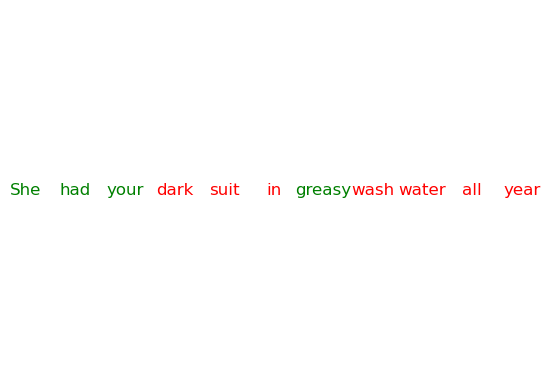

In [6]:
import matplotlib.pyplot as plt

def visualize_pronunciation(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    
    fig, ax = plt.subplots()
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(idx * 0.1, 0.5, word, color=color, fontsize=12, ha='center')
    ax.axis('off')
    plt.show()

# Call the visualization function
visualize_pronunciation(ground_truth_text, predicted_text)


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert words to binary labels for correct (1) and incorrect (0) pronunciation
def get_labels(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(ground_truth_words, predicted_words)]
    return labels

labels = get_labels(ground_truth_text, predicted_text)

# Assuming binary labels where 1 = correct, 0 = incorrect
accuracy = accuracy_score([1]*len(labels), labels)
precision = precision_score([1]*len(labels), labels)
recall = recall_score([1]*len(labels), labels)
f1 = f1_score([1]*len(labels), labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.40
Precision: 1.00
Recall: 0.40
F1 Score: 0.57
